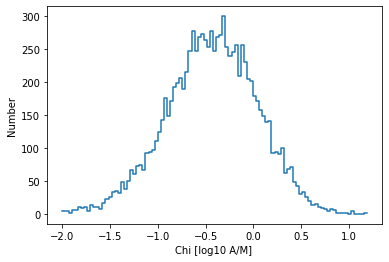

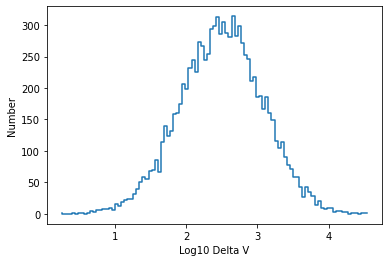

In [3]:
from BreakupModel import *
import numpy as np
import matplotlib.pyplot as plt

L = randL_coll(10000, 1/100, 1)
x = np.zeros(L.shape)
v = np.zeros(L.shape)
for i in range(len(L)):
    x[i] = randX_coll(1, -2, 2, L[i])
    v[i] = randv_coll(1, x[i])

hc,edgesc = np.histogram(x,100)
hv,edgesv = np.histogram(v,100)

import matplotlib.pylab as plt

plt.figure()
plt.step(edgesc[0:-1],hc)
plt.xlabel("Chi [log10 A/M] ")
plt.ylabel("Number")

plt.figure()
plt.step(edgesv[0:-1],hv)
plt.xlabel("Log10 Delta V")
plt.ylabel("Number")

plt.show()

In [12]:
from BreakupModel import *
import numpy as np
from scipy.integrate import quad, dblquad, tplquad
from scipy.stats import norm

L_min = 1/1000
L_max = 1
x_min = -2
x_max = 2
R = 6371
r = (R + 600)*1000
r2 = r + 25/2*1000
G = 6.67e-11
Me = 5.972e24
v0 = np.sqrt(G*Me/r)
v2 = np.sqrt(G*Me*(2/r-1/(2*r))-v0**2)

def pdf_L(L):
    beta = 1.71
    return (beta*L**(-(beta + 1)))/(L_min**(-beta) - L_max**(-beta))

def pdf_X(X, L):
    if L >= 11/100 : return _pdf_X_11(X, L)
    elif L <= 8/100 : return _pdf_X_8(X, L)
    else:
        lam_min, lam_max = np.log10(8/100), np.log10(11/100)
        P = (np.log10(L)-lam_min)/(lam_max-lam_min)
        return P*_pdf_X_11(X, L) + (1-P)*_pdf_X_8(X, L)

def _pdf_X_8(X, L):
    lam = np.log10(L)

    # define functions for determining normal distribution parameters
    def mu_soc(lambda_c):
        if lambda_c <= -1.75 : return -0.3
        elif lambda_c < -1.25 : return -0.3 - 1.4*(lambda_c + 1.75)
        else : return -1

    def sigma_soc(lambda_c):
        if lambda_c <= -3.5 : return 0.2
        else : return 0.2 + 0.1333*(lambda_c + 3.5)
    
    mu = mu_soc(lam) # calculate parameters
    sigma = sigma_soc(lam)
    C = 2/(erf((x_max-mu)/(np.sqrt(2)*sigma)) - erf((x_min-mu)/(np.sqrt(2)*sigma))) # normalization factor
    # compute total distribution
    return C*norm.pdf(X, loc=mu, scale=sigma)

def _pdf_X_11(X, L):

    lam = np.log10(L)

    # define functions for determining normal distribution parameters
    def alpha_sc(lambda_c):
            if lambda_c <= -1.95 : return 0
            elif lambda_c < 0.55 : return 0.3 + 0.4*(lambda_c + 1.2)
            else : return 1

    def mu1_sc(lambda_c):
        if lambda_c <= -1.1 : return -0.6
        elif lambda_c < 0 : return -0.6 - 0.318*(lambda_c + 1.1)
        else : return -0.95

    def sigma1_sc(lambda_c):
        if lambda_c <= -1.3 : return 0.1
        elif lambda_c < -0.3 : return 0.1 + 0.2*(lambda_c + 1.3)
        else : return 0.3

    def mu2_sc(lambda_c):
        if lambda_c <= -0.7 : return -1.2
        elif lambda_c < -0.1 : return -1.2 - 1.333*(lambda_c + 0.7)
        else : return -2

    def sigma2_sc(lambda_c):
        if lambda_c <= -0.5 : return 0.5
        elif lambda_c < -0.3 : return 0.5 - (lambda_c + 0.5)
        else : return 0.3
    
    mu1 = mu1_sc(lam) # calculate parameters
    sigma1 = sigma1_sc(lam)
    mu2 = mu2_sc(lam)
    sigma2 = sigma2_sc(lam)
    alpha = alpha_sc(lam)
    # compute normalization factor
    top = alpha*erf((x_max-mu1)/(np.sqrt(2)*sigma1)) + (1-alpha)*erf((x_max-mu2)/(np.sqrt(2)*sigma2))
    bot = alpha*erf((x_min-mu1)/(np.sqrt(2)*sigma1)) + (1-alpha)*erf((x_min-mu2)/(np.sqrt(2)*sigma2))
    C = 2/(top - bot)
    # compute total distribution
    fac_one = norm.pdf(X, loc=mu1, scale=sigma1)
    fac_two = norm.pdf(X, loc=mu2, scale=sigma2)
    return C*(alpha*fac_one + (1-alpha)*fac_two)

def pdf_v(v, X):
    mu = 0.9*X + 2.9 # calculate normal distribution parameters
    sigma = 0.4
    return norm.pdf(v, loc=mu, scale=sigma)

def pdf_vprim(V, x):
    del_v = np.sqrt(V**2-v0**2)
    return pdf_v(np.log10(del_v), x)*V/(np.log(10)*del_v**2)

def pdf_a(a, X):
    vprim = np.sqrt(G*Me*(2/r-1/a))
    return pdf_vprim(vprim, X)*(((2/r-(vprim**2)/(G*Me))**(-2))*(2*vprim)/(G*Me))**(-1)

def P(a, X, L):
    return pdf_L(L)*pdf_X(X, L)*pdf_a(a, X)

#print(quad(pdf_X, x_min, x_max, args=(0.01)))
#print(quad(pdf_a, r, 2*r, args=(0)))
#print(quad(pdf_v, -np.inf, np.log10(v2), args=(0)))
print(tplquad(P, L_min, L_max, x_min, x_max, r, r2))

(0.39906020770216155, 1.541810029642265e-05)


In [2]:
import numpy as np
L_min = 1/1000
L_max = 1
x_min = -2
x_max = 2
R = 6371
r = (R + 600)*1000
r2 = r + 25/2*1000
G = 6.67e-11
Me = 5.972e24
v0 = np.sqrt(G*Me/r)
v2 = np.sqrt(G*Me*(2/r-1/r2))
print(v0,v2)

7559.190237759489 7565.952436737351
